## Setup

In [1]:
%%capture
%run code.ipynb

In [2]:
sig_file_name = 'data/all_el.root'
bkg_file_name = 'data/all_mu.root'

# data
# sig_tree  = 'electron_tags'
# bkg_tree  = 'muons'

# MC
sig_tree  = 'electron_mc'
bkg_tree  = 'muon_mc'

output_path = 'plots'
make_path(output_path)

## Create eProbabilityHT curves

In [3]:
el_eprob = uproot.open(sig_file_name)[sig_tree].array('eProbHT')[:60000]
mu_eprob = uproot.open(bkg_file_name)[bkg_tree].array('eProbHT')[:60000]

roc_eprob_obj = eprob_roc_generateor(el_eprob, mu_eprob)

roc_eprob = [roc_eprob_obj.tpr(), roc_eprob_obj.fpr(), 'eProbabilityHT', 'eprob', 'black', '-']

## Setup variables to train on

In [4]:
variables = OrderedDict(p='default',
                        pT='default',
                        eta='symmetric',
                        nTRThitsMan='default',
                        nTRTouts='default',
                        fHTMB='default',
                        fAr='default',
                        trkOcc='default',
                        sumToTsumL='default')

# TODO formerly just [k for k in variables], but was getting out of order for mepland in python2.7
hard_coded_order = ['p',
    'pT',
    'eta',
    'nTRThitsMan',
    'nTRTouts',
    'fHTMB',
    'fAr',
    'trkOcc',
    'sumToTsumL']

# other vars
# lep_pT, phi
# nTRThits, nArhits, nXehits, nHThitsMan, nPrechitsMan, NhitsdEdx, sumToT, sumL, PHF

# all the hit_ vars
# eProbHT

In [5]:
sig_df, bkg_df, X_train, X_test, y_train, y_test = create_df_tts_scale(
    sig_file_name,sig_tree,bkg_file_name,bkg_tree,
    hard_coded_order,test_size=0.333333,
    sig_n=40000,bkg_n=40000,shuffle=True,scale_style={i:v for i,(_,v) in enumerate(variables.items())}
)

In [6]:
if False:
    print(X_train.shape)
    print(X_train[0])
    print(y_train.shape)
    print(y_train[0])
    print(X_train.shape[1])

## Plot input variables

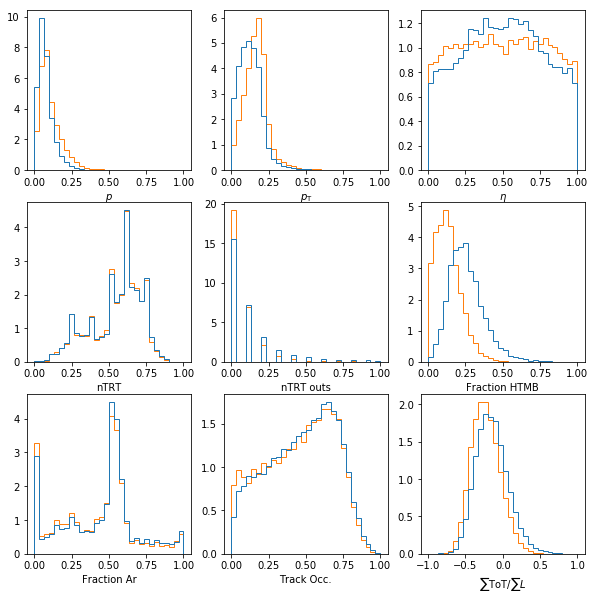

In [7]:
fig, axarr = plt.subplots(3,3,figsize=(10,10))
fortitles = {0:['$p$',axarr[0,0]],
             1:['$p_\mathrm{T}$',axarr[0,1]],
             2:['$\eta$',axarr[0,2]],
             3:['nTRT',axarr[1,0]],
             4:['nTRT outs',axarr[1,1]],
             5:['Fraction HTMB',axarr[1,2]],
             6:['Fraction Ar',axarr[2,0]],
             7:['Track Occ.',axarr[2,1]],
             8:['$\sum\mathrm{ToT}/\sum L$',axarr[2,2]]}

for k,v in fortitles.items():
    v[1].hist([X_train[:,k][y_train>0.5],X_train[:,k][y_train<0.5]],label=['Sig','Bkg'],bins=30,histtype='step',normed=True)
    v[1].set_xlabel(v[0])
fig.savefig(output_path+'/allvars.pdf')

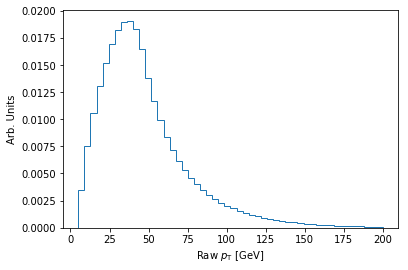

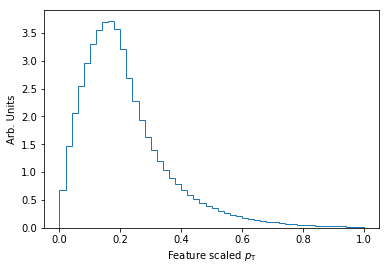

In [8]:
plot_scale_example(sig_file_name,sig_tree,output_path,'p')

## SVM (sklearn)

In [ ]:
# create model
svm1 = svm.SVC(#C=1.0, #kernel='rbf', #tol=0.001, #gamma='auto',
    probability=True);

In [ ]:
# train
svm1.fit(X_train,y_train)

In [ ]:
plot_classifier_1D_output(svm1.decision_function(X_test[y_test>0.5]), # el
                          svm1.decision_function(X_test[y_test<0.5]), # mu
                          'SVM', 'svm', output_path
                          #, 'Default sklearn.svm.SVC settings'
                         )

fpr_svm1, tpr_svm1, thresholds_svm1 = roc_curve(y_test, svm1.decision_function(X_test))
roc_svm1 = [tpr_svm1, fpr_svm1, 'SVM', 'svm', 'blue', '--']

plot_roc([roc_eprob, roc_svm1], output_path)

# Keras / Tensorflow work

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

# fix random seed for reproducibility
np.random.seed(7)

input_dimensions = X_train.shape[1]

### Default

In [ ]:
# create model_default
model_default = Sequential()
model_default.add(Dense(12, input_dim=input_dimensions, activation='relu'))
model_default.add(Dense(8, activation='relu'))
model_default.add(Dense(1, activation='sigmoid'))

model_default.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# train model_default
model_default.fit(X_train, y_train, epochs=300, batch_size=50, verbose=0);

In [ ]:
# evaluate model_default
print("model_default %s: %.2f%%" % (model_default.metrics_names[1], model_default.evaluate(X_test,y_test,verbose=0)[1]*100))


plot_classifier_1D_output(model_default.predict(X_test[y_test>0.5], verbose=0), # el
                          model_default.predict(X_test[y_test<0.5], verbose=0), # mu
                          'NN (Default)', 'nn_default', output_path
                         )

fpr_model_default, tpr_model_default, thresholds_model_default = roc_curve(y_test, model_default.predict(X_test, verbose=0))
roc_model_default = [tpr_model_default, fpr_model_default, 'NN (Default)', 'nn_default', 'orange', ':']

plot_roc([roc_eprob, roc_model_default], output_path)

### Wide

In [ ]:
# create model_wide
model_wide = Sequential()
model_wide.add(Dense(24, input_dim=input_dimensions, activation='relu'))
model_wide.add(Dense(16, activation='relu'))
model_wide.add(Dense(1, activation='sigmoid'))

model_wide.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# train model_wide
model_wide.fit(X_train, y_train, epochs=300, batch_size=50, verbose=0);

In [ ]:
# evaluate model_wide
print("model_wide %s: %.2f%%" % (model_wide.metrics_names[1], model_wide.evaluate(X_test,y_test,verbose=0)[1]*100))


plot_classifier_1D_output(model_wide.predict(X_test[y_test>0.5], verbose=0), # el
                          model_wide.predict(X_test[y_test<0.5], verbose=0), # mu
                          'NN (wide)', 'nn_wide', output_path
                         )

fpr_model_wide, tpr_model_wide, thresholds_model_wide = roc_curve(y_test, model_wide.predict(X_test, verbose=0))
roc_model_wide = [tpr_model_wide, fpr_model_wide, 'NN (wide)', 'nn_wide', 'cyan', '-.']

plot_roc([roc_eprob, roc_model_wide], output_path)

### Deep

In [ ]:
# create model_deep
model_deep = Sequential()
model_deep.add(Dense(12, input_dim=input_dimensions, activation='relu'))
model_deep.add(Dense(8, activation='relu'))
model_deep.add(Dense(8, activation='relu'))
model_deep.add(Dense(8, activation='relu'))
model_deep.add(Dense(8, activation='relu'))
model_deep.add(Dense(1, activation='sigmoid'))

model_deep.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# train model_deep
model_deep.fit(X_train, y_train, epochs=300, batch_size=50, verbose=0);

In [ ]:
# evaluate model_deep
print("model_deep %s: %.2f%%" % (model_deep.metrics_names[1], model_deep.evaluate(X_test,y_test,verbose=0)[1]*100))


plot_classifier_1D_output(model_deep.predict(X_test[y_test>0.5], verbose=0), # el
                          model_deep.predict(X_test[y_test<0.5], verbose=0), # mu
                          'NN (deep)', 'nn_deep', output_path
                         )

fpr_model_deep, tpr_model_deep, thresholds_model_deep = roc_curve(y_test, model_deep.predict(X_test, verbose=0))
roc_model_deep = [tpr_model_deep, fpr_model_deep, 'NN (deep)', 'nn_deep', 'magenta', '--']

plot_roc([roc_eprob, roc_model_deep], output_path)

### Compare all models

In [ ]:
all_models = []
all_models.append(roc_eprob)
all_models.append(roc_svm1)
all_models.append(roc_model_default)
all_models.append(roc_model_wide)
all_models.append(roc_model_deep)

plot_roc(all_models, output_path)